# Exercise 2: Sub-cellular targeting of cell types in the mouse visual cortex

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
At the end of Workshop 1, we saw how to get labels on whether synapses were onto spines,
dendritic shafts, or somas. We also plotted this data as adjacency matrices, and made some
qualitative observations about the connectivity of different cell types in the context of 
those connection types.

Here, we'll go through a few steps to turn that into quantifications, specifically, what
fraction of connections between cell types use spines, dendritic shafts, or somas.

</div>


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
We'll start by loading up much of the same data from Workshop 1.
</div>

In [ ]:
# Import packages
import sys
from os.path import join as pjoin
import platform

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Add the directory for the data and utilities
mat_version = 1196

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_root = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2025/"

# Set the directory to load prepared data and utility code
data_dir = pjoin(data_root, f"v1dd_{mat_version}")
utils_dir = pjoin("..", "utils")

# Add utilities to path
sys.path.append(utils_dir)

Using data directory: /Users/ben.pedigo/code/swdb/SWDB_2025_Connectomics/data/v1dd_1196
Using utils directory: /Users/ben.pedigo/code/swdb/SWDB_2025_Connectomics/code/utils


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
Load proofreading information about cells:
</div>

In [4]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_dendrite_list_{mat_version}.npy")
)
axon_proof_root_ids = np.load(pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

proof_root_ids = np.intersect1d(dendrite_proof_root_ids, axon_proof_root_ids)

proof_root_ids

array([864691132534275418, 864691132534315610, 864691132535664474, ...,
       864691133313558608, 864691133313636944, 864691133313665616],
      shape=(1148,))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
Load synapses:
</div>

In [5]:
syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather"
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
Filter to synapses between proofread cells:
</div>

In [ ]:
from utils import filter_synapse_table

proof_syn_df = filter_synapse_table(syn_df, proof_root_ids, proof_root_ids)

# we're going to copy proof_syn_df to avoid modifying the original DataFrame -
# pandas will often yell at you if you try to modify a DataFrame that is a view of
# another DataFrame
proof_syn_df = proof_syn_df.copy()

proof_syn_df.set_index("id", inplace=True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
Load cell information:
</div>

In [7]:
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")
cell_df.set_index("pt_root_id", inplace=True)
cell_df = cell_df.loc[proof_root_ids]
cell_df.head()

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,volume,cell_type_coarse,cell_type
pt_root_id,,,,,,,,,,
864691132534275418,295434,739373,633371,323640,-149843.151941,313619.432165,40652.766510,224.683217,E,L4-IT
864691132534315610,294489,823103,635932,272970,-64431.224685,301977.525829,-9080.417561,236.639903,E,L4-IT
864691132535664474,398771,972173,1006782,429480,-56727.602065,731348.504426,-1565.522767,300.366081,E,L6-CT
864691132536286810,308151,860041,818137,270495,-68294.259179,481953.279927,-64048.160336,278.909677,I,DTC
864691132536904794,366084,940822,738674,146565,41834.402292,367661.880467,-158078.097546,273.808765,I,DTC


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
Load synapse target information: 
</div>

In [8]:
target_structure = pd.read_feather(
    pjoin(data_dir, f"syn_label_df_all_to_proofread_to_all_{mat_version}.feather")
)["tag"]
target_structure

# Combine the target information to the proofread synapses table
proof_syn_df["target_structure"] = target_structure
proof_syn_df["target_structure"] = proof_syn_df["target_structure"].fillna("unknown")
print(proof_syn_df["target_structure"].value_counts())

target_structure
shaft      134631
spine       45679
soma        13248
unknown      1746
Name: count, dtype: int64


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
Now that we have all of that data loaded up, we'll start by focusing on what information we need to select and combine. These are the columns in the synapse table we'll focus on:
</div>

In [ ]:
proof_syn_df[["pre_pt_root_id", "post_pt_root_id", "target_structure"]].head()

,pre_pt_root_id,post_pt_root_id,target_structure
id,,,
461895313,864691132557909513,864691132931817448,shaft
301049004,864691132578625044,864691132931817448,shaft
436596114,864691132557909513,864691132931817448,shaft
363374679,864691132578625044,864691132786109590,shaft
491726200,864691132562471396,864691132773784759,shaft


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

We have a table of synapses, but we first want to know what cell types are involved for each.
Although it is a little redundant, it is often useful to simply include the pre- and post-synaptic
cell types in the synapse table. There are many ways to accomplish this in Pandas - a
hint for one option is to use a column's [`.map()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html#pandas.Series.map) method.

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b> Use `.map()` or another method of your choosing to make two new columns in the synapse table:
`proof_syn_df['pre_cell_type']` and `proof_syn_df['post_cell_type']`. The former should
contain the cell type of the pre-synaptic cell for that row's synapse, and the latter
should contain the cell type of the corresponding post-synaptic cell type.

</div>


In [10]:
# TODO remove
proof_syn_df["pre_cell_type"] = proof_syn_df["pre_pt_root_id"].map(cell_df["cell_type"])
proof_syn_df["post_cell_type"] = proof_syn_df["post_pt_root_id"].map(
    cell_df["cell_type"]
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

With this information in hand, let's start with just counting the number of synapses
between each pair of cell types and in each target structure category.

In Pandas, [`.groupby()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)
is often key to aggregating data. Groupby takes a column name or list of column names, and
then allows you to apply an aggregation function to subsets of the data that share the same values
of those columns. For example, another way to count the total number of synapses in our
table in each target structure category is to do:

</div>


In [11]:
proof_syn_df.groupby(
    "target_structure",
    as_index=False,  # this makes the grouping variable(s) into columns instead of the index
).size()  # .size() is a pandas method which counts the number of rows in each group

,target_structure,size
0,shaft,134631
1,soma,13248
2,spine,45679
3,unknown,1746


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

Just to show the flexibility of `groupby`: this code will group by the `pre_pt_root_id` which indexes the pre-synaptic cell,
select the `ctr_pt_position_y` column which represents the depth of each synapse in nanometers, 
and then compute the mean depth of those synapses from each cell.
</div>

In [12]:
(
    proof_syn_df.groupby("pre_pt_root_id", as_index=False)[
        "ctr_pt_position_y"  # this is selecting a column "ctr_pt_position_y" by name
    ].mean()  # this is a pandas method which computes the mean of the selected column per group
)

,pre_pt_root_id,ctr_pt_position_y
0,864691132534275418,694276.248387
1,864691132534315610,654580.013415
2,864691132535664474,909937.600000
3,864691132536286810,763868.042560
4,864691132536904794,619347.957317
...,...,...
1142,864691133311980112,709252.160294
1143,864691133312850768,662119.624490
1144,864691133313558608,834249.919512
1145,864691133313636944,959922.409756


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

More extensive tutorials on `groupby` can be found in the [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/groupby.html).

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

Your turn! Returning to our problem of synapse categories and cell types, let's make a new DataFrame that counts the number of synapses between each pair of
cell types in each target structure category. 

For instance, one row might represent the information "there are 38 synapses from L2-IT cells to L3-IT cell shafts". 

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b>  Create a DataFrame that has four columns:
- `pre_cell_type`
- `post_cell_type`
- `target_structure`
- `size` (the number of synapses between the pre- and post-synaptic cell types in that target structure)

</div>

<div style="background: #f6d5f2ff; border-radius: 3px; padding: 10px;">

Hint: `.groupby()` can take a list of column names to group on!

</div>

In [21]:
# TODO remove
group_structure_counts = proof_syn_df.groupby(
    ["pre_cell_type", "post_cell_type", "target_structure"],
    as_index=False,
).size()
group_structure_counts

,pre_cell_type,post_cell_type,target_structure,size
0,DTC,DTC,shaft,3011
1,DTC,DTC,soma,87
2,DTC,DTC,spine,449
3,DTC,ITC,shaft,4576
4,DTC,ITC,soma,339
...,...,...,...,...
348,STC,PTC,soma,29
349,STC,PTC,spine,22
350,STC,STC,shaft,345
351,STC,STC,soma,28


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

Now, because we are interested in the _proportion_ of synapses in each cell type pair, we
also need to know the total number of synapses between each pair of cell types, regardless
of target structure.


</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b>  Create another dataframe called `group_total_counts`. It should have
columns for `pre_cell_type`, `post_cell_type`, and `total_size` (the total number of synapses
between the pre- and post-synaptic cell types, regardless of target structure). 

</div>


<div style="background: #f6d5f2ff; border-radius: 3px; padding: 10px;">

Hint: you might find it useful to use `.rename(columns={"old_name": "new_name"})` to 
rename the `size` column to `total_size`.

</div>


In [22]:
# TODO remove
group_total_counts = (
    group_structure_counts.groupby(["pre_cell_type", "post_cell_type"], as_index=False)[
        "size"
    ]
    .sum()
    .rename(columns={"size": "total_size"})
)

# OR

group_total_counts = (
    proof_syn_df.groupby(["pre_cell_type", "post_cell_type"], as_index=False)
    .size()
    .rename(columns={"size": "total_size"})
)
group_total_counts

,pre_cell_type,post_cell_type,total_size
0,DTC,DTC,3549
1,DTC,ITC,5410
2,DTC,L2-IT,6372
3,DTC,L3-IT,18131
4,DTC,L4-IT,4932
...,...,...,...
138,STC,L5-NP,26
139,STC,L6-CT,49
140,STC,L6-IT,125
141,STC,PTC,699


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

Now, let's think about how to join these tables together. As usual, there are many ways
to do this in Pandas, but one option is to use the [`.merge()`](https://pandas.pydata.org/docs/reference/api/pandas.merge.html) method. This method takes
two DataFrames and joins them together based on one or more columns that they share.
Think about what columns we want to join on! 
</div>


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b> Use `.merge()` to create a new
DataFrame called `group_counts` that contains the following columns:
- `pre_cell_type`
- `post_cell_type`
- `target_structure`
- `size` (the number of synapses between the pre- and post-synaptic cell types in that target structure)
- `total_size` (the total number of synapses between the pre- and post-synaptic cell types, regardless of target structure)

</div>



In [23]:
# TODO remove
group_counts = pd.merge(
    group_structure_counts,
    group_total_counts,
    on=["pre_cell_type", "post_cell_type"],
)
group_counts

,pre_cell_type,post_cell_type,target_structure,size,total_size
0,DTC,DTC,shaft,3011,3549
1,DTC,DTC,soma,87,3549
2,DTC,DTC,spine,449,3549
3,DTC,ITC,shaft,4576,5410
4,DTC,ITC,soma,339,5410
...,...,...,...,...,...
348,STC,PTC,soma,29,699
349,STC,PTC,spine,22,699
350,STC,STC,shaft,345,472
351,STC,STC,soma,28,472


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

Now that we've gone to all that trouble to align our data in this single table, it should
be easy to calculate the _proportion_ of synapses in each target structure category for each
pair of cell types.

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b> Add a new column to `group_counts` called `proportion`, which is the
`size` divided by `total_size`.

</div>

In [24]:
# TODO remove
group_counts["proportion"] = group_counts["size"] / group_counts["total_size"]
group_counts

,pre_cell_type,post_cell_type,target_structure,size,total_size,proportion
0,DTC,DTC,shaft,3011,3549,0.848408
1,DTC,DTC,soma,87,3549,0.024514
2,DTC,DTC,spine,449,3549,0.126515
3,DTC,ITC,shaft,4576,5410,0.845841
4,DTC,ITC,soma,339,5410,0.062662
...,...,...,...,...,...,...
348,STC,PTC,soma,29,699,0.041488
349,STC,PTC,spine,22,699,0.031474
350,STC,STC,shaft,345,472,0.730932
351,STC,STC,soma,28,472,0.059322


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

We have what we said we wanted to compute - but let's transform it a bit to make it 
easier to plot. The code below will first query to select the proportions of synapses onto spines, 
and then [pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) the DataFrame to make it square matrix which we'll plot.

</div>

In [25]:
square_spine_counts = group_counts.query("target_structure == 'spine'").pivot(
    index="pre_cell_type", columns="post_cell_type", values="proportion"
)

# to make our plot look nicer, this code just reorders the categories to be first by
# excitatory/inhibitory, then by layer, and finally by cell type
categories = [
    "L2-IT",  # excitatory cell types
    "L3-IT",
    "L4-IT",
    "L5-IT",
    "L5-ET",
    "L5-NP",
    "L6-IT",
    "L6-CT",
    "DTC",  # inhibitory cell types
    "ITC",
    "PTC",
    "STC",
]
square_spine_counts = square_spine_counts.reindex(index=categories, columns=categories)
square_spine_counts

post_cell_type,L2-IT,L3-IT,L4-IT,L5-IT,L5-ET,L5-NP,L6-IT,L6-CT,DTC,ITC,PTC,STC
pre_cell_type,,,,,,,,,,,,
L2-IT,0.915114,0.929603,0.954545,0.903704,0.871145,0.500000,0.736842,0.900000,0.291408,0.151235,0.070913,0.223938
L3-IT,0.912000,0.923630,0.899371,0.918033,0.889861,0.428571,0.907407,0.892857,0.221413,0.135283,0.054801,0.234375
L4-IT,0.924528,0.944578,0.896104,0.900826,0.920110,NaN,1.000000,0.852941,0.193565,0.054545,0.031771,0.210000
L5-IT,0.960526,0.962428,0.900000,0.868421,0.882045,0.230769,0.954545,0.852941,0.219959,0.116822,0.050510,0.230159
L5-ET,0.793103,0.865854,0.625000,0.826087,0.649351,0.729730,0.629630,0.875000,0.375701,0.152174,0.096711,0.235294
L5-NP,0.800000,0.714286,1.000000,0.520000,0.276151,NaN,0.956522,0.950000,0.157068,0.057692,0.063889,0.176471
L6-IT,0.833333,1.000000,1.000000,0.800000,0.692308,0.500000,0.887324,0.956522,0.130781,0.285714,0.050598,0.173913
L6-CT,NaN,1.000000,NaN,0.666667,0.234375,0.071429,0.900000,0.956522,0.105802,NaN,0.025788,0.200000
DTC,0.249686,0.235232,0.234996,0.281485,0.244227,0.160377,0.384892,0.239819,0.126515,0.091312,0.036316,0.101086


<Axes: xlabel='post_cell_type', ylabel='pre_cell_type'>

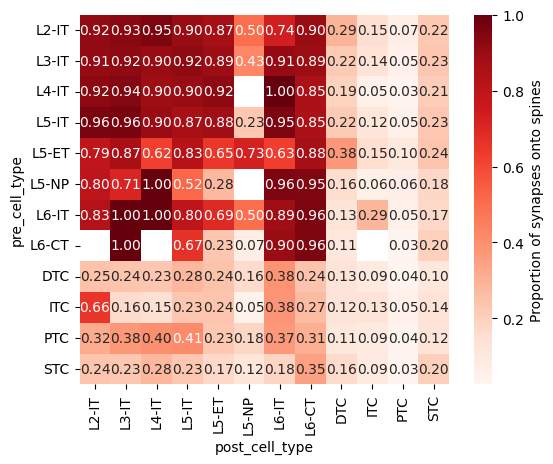

In [35]:
sns.heatmap(
    square_spine_counts,
    annot=True,
    cmap="Reds",
    cbar_kws={"label": "Proportion of synapses onto spines"},
    square=True,
    fmt=".2f",  # format the annotations to 2 decimal places
)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; background: #F0FAFF;">

<b> Task: </b> Now, create similar plots for the other target structures. 

</div>

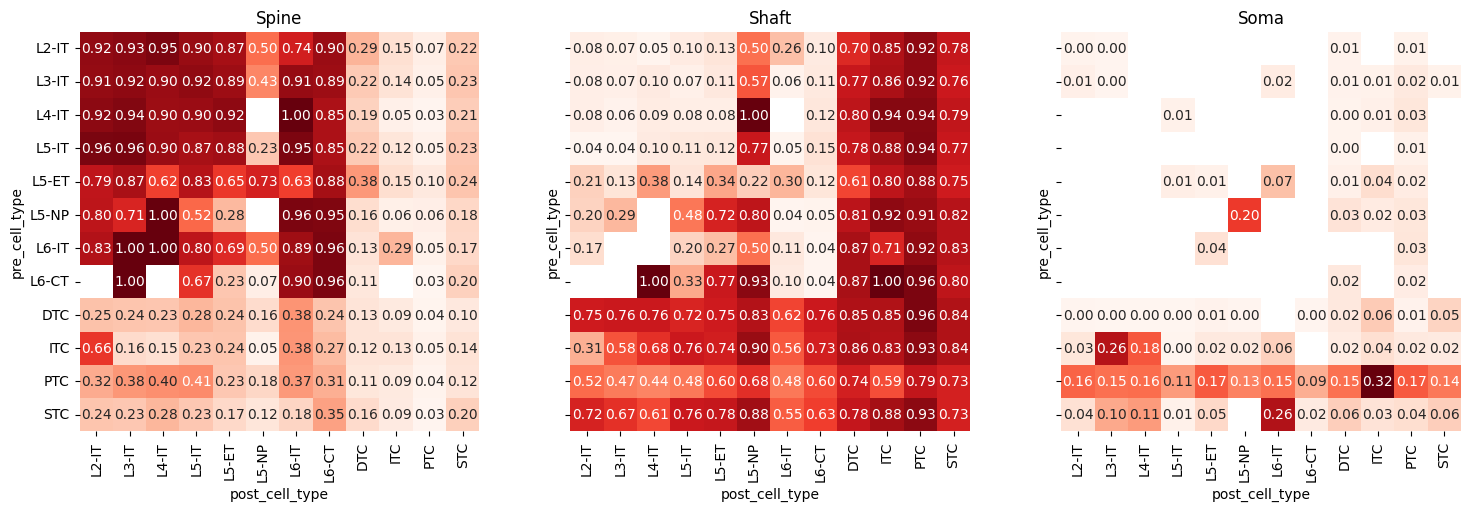

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, layout="constrained")

for i, target_structure in enumerate(["spine", "shaft", "soma"]):
    square_counts = group_counts.query(
        f"target_structure == '{target_structure}'"
    ).pivot(index="pre_cell_type", columns="post_cell_type", values="proportion")

    square_counts = square_counts.reindex(index=categories, columns=categories)

    sns.heatmap(
        square_counts,
        annot=True,
        cmap="Reds",
        cbar_kws={"label": "Proportion of synapses onto " + target_structure},
        ax=axs[i],
        square=True,
        cbar=False,
        fmt=".2f",  # format the annotations to 2 decimal places
    )

    axs[i].set_title(target_structure.capitalize())


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Question: </b> What general trends do you notice about what connection types are using what "channels" of synaptic targeting? What sources of bias might affect the reliability of these proportions?

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Bonus task: </b> How much more common are synapses onto spines for excitatory cells compared to inhibitory cells? Compute the proportion of synapses onto spines for each individual cell using the same tools we developed above. 

</div>

<div style="background: #f6d5f2ff; border-radius: 3px; padding: 10px;">

<b> Hint: </b> you will want a different filter on the synapse table than we used here (why?). 

</div>

<Axes: xlabel='p_spine', ylabel='Count'>

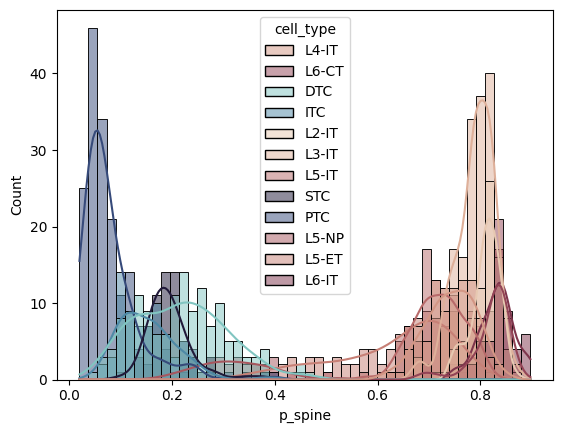

In [19]:
proof_syn_df = (
    filter_synapse_table(syn_df, post_root_ids=proof_root_ids).set_index("id").copy()
)
proof_syn_df["pre_cell_type"] = proof_syn_df["pre_pt_root_id"].map(cell_df["cell_type"])
proof_syn_df["post_cell_type"] = proof_syn_df["post_pt_root_id"].map(
    cell_df["cell_type"]
)
proof_syn_df["target_structure"] = target_structure
cell_structure_counts = proof_syn_df.groupby(
    ["post_pt_root_id", "target_structure"], as_index=False
).size()
cell_total_counts = (
    proof_syn_df.groupby("post_pt_root_id", as_index=False)
    .size()
    .rename(columns={"size": "total_size"})
)
cell_structure_counts = pd.merge(
    cell_structure_counts,
    cell_total_counts,
    on="post_pt_root_id",
)
cell_structure_counts["proportion"] = (
    cell_structure_counts["size"] / cell_structure_counts["total_size"]
)

cell_proportions = cell_structure_counts.pivot(
    index="post_pt_root_id", columns="target_structure", values="proportion"
).rename(columns=lambda x: f"p_{x}")
cell_proportions["cell_type"] = cell_proportions.index.map(cell_df["cell_type"])

from utils import cell_type_palette

sns.histplot(
    cell_proportions,
    x="p_spine",
    kde=True,
    bins=50,
    hue="cell_type",
    palette=cell_type_palette,
)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b>Question:<b> How does this one feature perform as a classifier for excitatory vs. inhibitory cells? What would be the drawbacks of using this feature as a classifier in practice? 

</div>